# MNIST with SciKit-Learn and skorch

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [1]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [2]:
pip install medmnist

In [5]:
#%%
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from medmnist import PathMNIST

In [22]:
mnist = PathMNIST
mnist

medmnist.dataset.PathMNIST

In [21]:
mnist(split="train" ,download=True)

100%|██████████| 206M/206M [04:27<00:00, 769kB/s]


Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K

In [24]:
mnist_train = mnist(split="train")
mnist_test = mnist(split="test")

print(mnist_test)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 7180
    Root location: /root/.medmnist
    Split: test
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K i

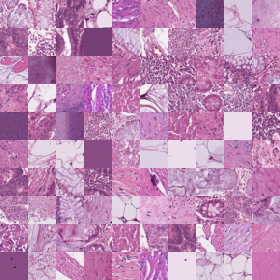

In [28]:
mnist_train.montage(length=10)

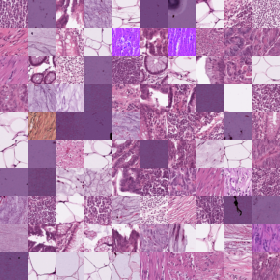

In [29]:

mnist_test.montage(length=10)

In [31]:
mnist_train.imgs.shape, mnist_test.imgs.shape

((89996, 28, 28, 3), (7180, 28, 28, 3))

In [45]:
type(mnist_train.imgs), mnist_train.imgs[0]

(numpy.ndarray,
 array([[[220, 208, 227],
         [219, 207, 227],
         [220, 207, 227],
         ...,
         [220, 208, 227],
         [219, 207, 227],
         [221, 208, 227]],
 
        [[218, 206, 226],
         [220, 207, 226],
         [219, 206, 226],
         ...,
         [197, 177, 202],
         [192, 172, 197],
         [190, 168, 195]],
 
        [[220, 208, 226],
         [220, 207, 226],
         [219, 205, 225],
         ...,
         [208, 191, 213],
         [207, 192, 213],
         [209, 194, 216]],
 
        ...,
 
        [[218, 205, 225],
         [217, 201, 222],
         [221, 208, 227],
         ...,
         [221, 208, 227],
         [220, 208, 227],
         [221, 209, 227]],
 
        [[213, 192, 218],
         [217, 200, 222],
         [221, 208, 227],
         ...,
         [221, 208, 227],
         [221, 209, 227],
         [221, 208, 227]],
 
        [[215, 195, 220],
         [220, 207, 226],
         [221, 208, 227],
         ...,
         [22

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [8]:
#X = mnist.data.astype('float32')
#y = mnist.target.astype('int64')

In [108]:
X_train = mnist_train.imgs.astype('float32')
y_train = mnist_train.labels.astype('int64')
X_test = mnist_test.imgs.astype('float32')
y_test = mnist_test.labels.astype('int64')

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [134]:
X_train /= 255.0
X_test /= 255.0

In [135]:
X_train.min(), X_train.max()
X_test.min(), X_test.max()

(np.float32(0.0), np.float32(1.0))

Note: data is not normalized.

In [11]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [12]:
#assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [136]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89996, 28, 28, 3), (7180, 28, 28, 3), (89996, 1), (7180, 1))

In [137]:
X_train[1]

array([[[0.49411765, 0.23137255, 0.46666667],
        [0.5568628 , 0.32941177, 0.54509807],
        [0.68235296, 0.49803922, 0.6901961 ],
        ...,
        [0.45882353, 0.23137255, 0.4392157 ],
        [0.60784316, 0.3764706 , 0.5686275 ],
        [0.79607844, 0.58431375, 0.7490196 ]],

       [[0.7294118 , 0.54509807, 0.7137255 ],
        [0.6784314 , 0.47058824, 0.6666667 ],
        [0.6156863 , 0.3647059 , 0.5803922 ],
        ...,
        [0.77254903, 0.6392157 , 0.77254903],
        [0.78039217, 0.6156863 , 0.7647059 ],
        [0.77254903, 0.5764706 , 0.74509805]],

       [[0.7372549 , 0.59607846, 0.7294118 ],
        [0.7882353 , 0.6666667 , 0.79607844],
        [0.7647059 , 0.5882353 , 0.7411765 ],
        ...,
        [0.8156863 , 0.70980394, 0.827451  ],
        [0.81960785, 0.7137255 , 0.83137256],
        [0.7882353 , 0.654902  , 0.79607844]],

       ...,

       [[0.7607843 , 0.45490196, 0.6666667 ],
        [0.7647059 , 0.47058824, 0.6784314 ],
        [0.7921569 , 0

### Print a selection of training images and their labels

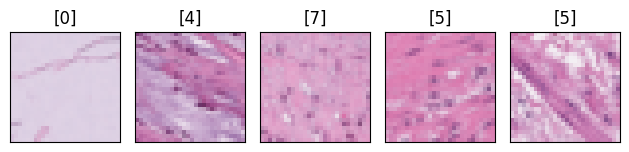

In [138]:
import matplotlib.pyplot as plt
def plot_example(X, y, n=5):
    """Plot the first n images and their labels in a row."""
    #plt.figure(figsize=(n, 3))  # Adjust figure size based on n
    for i, (img, y) in enumerate(zip(X[:n], y[:n])):
        plt.subplot(1, n, i + 1)  # Use 1, n, i+1 for subplot grid
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)
    plt.tight_layout() # Adjust layout to prevent titles overlapping
    plt.show() # Display the plot
plot_example(X_train, y_train, n=5) # Example of plotting the first n images

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [69]:
import torch
from torch import nn
import torch.nn.functional as F

In [70]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [73]:
mnist_dim = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(y_train))

In [74]:
mnist_dim, hidden_dim, output_dim

(2352, 294, 9)

A Neural network in PyTorch's framework.

In [84]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        # Flatten the input
        X = X.view(X.size(0), -1)
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [80]:
from skorch import NeuralNetClassifier

In [81]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [82]:
net.fit(X_train, y_train);

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

## Prediction

In [99]:
from sklearn.metrics import accuracy_score

In [100]:
y_pred = net.predict(X_test)

In [101]:
accuracy_score(y_test, y_pred)

0.9631428571428572

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [114]:
error_mask = y_pred != y_test.ravel() # Flatten y_test here

NameError: name 'y_pred' is not defined

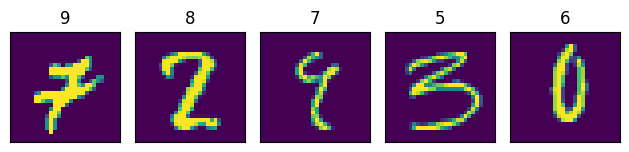

In [103]:
plot_example(X_test[error_mask], y_pred[error_mask])

# Convolutional Network
## Simple CNN
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28).

In [104]:
#XCnn = X.reshape(-1, 1, 28, 28)

In [87]:
#XCnn.shape

In [106]:
#XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [139]:
#XCnn_train.shape, y_train.shape
X_train.shape, y_train.shape

((89996, 28, 28, 3), (89996, 1))

In [143]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3) # Changed input channels to 3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        # Reorder dimensions to be (batch_size, channels, height, width)
        x = x.permute(0, 3, 1, 2)

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flatten over channel, height and width = 1600
        x = x.reshape(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [144]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [145]:
cnn.fit(X_train, y_train.ravel()); # Flatten y_train here

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6955       0.5277        1.2518  3.4530
      2        1.3464       0.5922        1.1141  3.7946
      3        1.2235       0.6423        1.0042  3.2900
      4        1.1451       0.6655        0.9474  3.3645
      5        1.1087       0.6723        0.9408  3.7184
      6        1.0821       0.6668        0.9241  3.4352
      7        1.0645       0.6474        0.9428  3.3496
      8        1.0383       0.6494        0.9324  3.3371
      9        1.0106       0.6938        0.8731  3.7310
     10        1.0083       0.6785        0.9129  3.3265


In [146]:
y_pred_cnn = cnn.predict(X_test)

In [147]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.ravel(), y_pred_cnn) # Flatten y_test here

0.747075208913649

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [148]:
error_mask = y_pred_cnn != y_test.ravel() # Calculate error mask for CNN predictions
accuracy_score(y_test.ravel()[error_mask], y_pred_cnn[error_mask]) # Flatten y_test here

0.0

Over 70% of the previously misclassified images are now correctly identified.

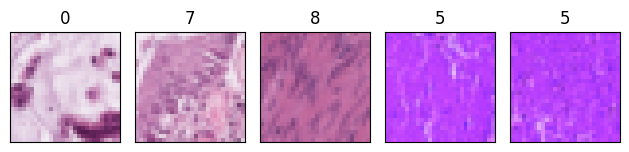

In [149]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask], n=5) # Misclassified images with CNN predicted labels

TypeError: Invalid shape (7180, 28, 28, 3) for image data

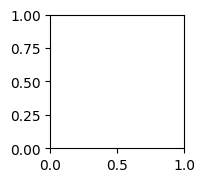

In [186]:
plot_example_tensor(X_test[error_mask], y_test.ravel()[error_mask], n=5) # Misclassified images with their actual labels (using plot_example_tensor and numpy input)

## Multilayer CNN

Construct the model

In [170]:
#%%
# 定义超参数
input_size = 28  #图像的总尺寸28*28
num_classes = 9  #标签的种类数
num_epochs = 3  #训练的总循环周期
batch_size = 64  #一个撮（批次）的大小，64张图片

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long().ravel() # Use long() and flatten for target labels
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long().ravel() # Use long() and flatten for target labels

# Create TensorDatasets
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# 构建batch数据
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False) # No need to shuffle test data

In [171]:
train_dataset #怎么显示size??

In [167]:
#%%
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # 输入大小 (3, 28, 28)
            nn.Conv2d(
                in_channels=3,              # 灰度图
                out_channels=16,            # 要得到几多少个特征图
                kernel_size=5,              # 卷积核大小
                stride=1,                   # 步长
                padding=2,                  # 如果希望卷积后大小跟原来一样，需要设置padding=(kernel_size-1)/2 if stride=1
            ),                              # 输出的特征图为 (16, 28, 28)
            nn.ReLU(),                      # relu层
            nn.MaxPool2d(kernel_size=2),    # 进行池化操作（2x2 区域）, 输出结果为： (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # 下一个套餐的输入 (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # 输出 (32, 14, 14)
            nn.ReLU(),                      # relu层
            nn.Conv2d(32, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),                # 输出 (32, 7, 7)
        )

        self.conv3 = nn.Sequential(         # 下一个套餐的输入 (16, 14, 14)
            nn.Conv2d(32, 64, 5, 1, 2),     # 输出 (32, 14, 14)
            nn.ReLU(),             # 输出 (32, 7, 7)
        )

        self.out = nn.Linear(64 * 7 * 7, 9)   # 全连接层得到的结果 (Changed output size to 9)

    def forward(self, x):
        # Reorder dimensions to be (batch_size, channels, height, width)
        x = x.permute(0, 3, 1, 2)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.reshape(x.size(0), -1)           # flatten操作，结果为：(batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output

Train the model

In [172]:
#%%
def accuracy(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels)

In [173]:
#%%
# 实例化
net = CNN()
#损失函数
criterion = nn.CrossEntropyLoss()
#优化器
optimizer = optim.Adam(net.parameters(), lr=0.001) #定义优化器，普通的随机梯度下降算法

#开始训练循环
for epoch in range(num_epochs):
    #当前epoch的结果保存下来
    train_rights = []

    for batch_idx, (data, target) in enumerate(train_loader):  #针对容器中的每一个批进行循环
        net.train()
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = accuracy(output, target)
        train_rights.append(right)


        if batch_idx % 100 == 0:

            net.eval()
            val_rights = []

            for (data, target) in test_loader:
                output = net(data)
                right = accuracy(output, target)
                val_rights.append(right)

            #准确率计算
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))

            print('当前epoch: {} [{}/{} ({:.0f}%)]\t损失: {:.6f}\t训练集准确率: {:.2f}%\t测试集正确率: {:.2f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data,
                100. * train_r[0].numpy() / train_r[1],
                100. * val_r[0].numpy() / val_r[1]))

当前epoch: 0 [0/89996 (0%)]	损失: 2.200032	训练集准确率: 6.25%	测试集正确率: 16.45%
当前epoch: 0 [6400/89996 (7%)]	损失: 1.549937	训练集准确率: 26.24%	测试集正确率: 42.73%
当前epoch: 0 [12800/89996 (14%)]	损失: 1.660311	训练集准确率: 33.06%	测试集正确率: 50.10%
当前epoch: 0 [19200/89996 (21%)]	损失: 1.186593	训练集准确率: 37.03%	测试集正确率: 52.38%
当前epoch: 0 [25600/89996 (28%)]	损失: 1.213274	训练集准确率: 40.64%	测试集正确率: 62.37%
当前epoch: 0 [32000/89996 (36%)]	损失: 1.046162	训练集准确率: 43.85%	测试集正确率: 66.95%
当前epoch: 0 [38400/89996 (43%)]	损失: 1.130670	训练集准确率: 46.70%	测试集正确率: 65.00%
当前epoch: 0 [44800/89996 (50%)]	损失: 0.846318	训练集准确率: 48.82%	测试集正确率: 68.69%
当前epoch: 0 [51200/89996 (57%)]	损失: 0.845994	训练集准确率: 50.54%	测试集正确率: 61.11%
当前epoch: 0 [57600/89996 (64%)]	损失: 0.933732	训练集准确率: 52.10%	测试集正确率: 63.76%
当前epoch: 0 [64000/89996 (71%)]	损失: 1.272687	训练集准确率: 53.22%	测试集正确率: 67.37%
当前epoch: 0 [70400/89996 (78%)]	损失: 0.846233	训练集准确率: 54.35%	测试集正确率: 72.92%
当前epoch: 0 [76800/89996 (85%)]	损失: 1.059346	训练集准确率: 55.43%	测试集正确率: 68.08%
当前epoch: 0 [83200/89996 (92%)]	损失: 1.087096	训练

In [182]:
y_pred_tensor = cnn.predict(test_dataset)
error_mask = y_pred_tensor != y_test_tensor.ravel() # Calculate error mask for CNN predictions